In [7]:
import pandas as pd

#loading files
dev_data = pd.read_csv("friends_dev.csv")
test_data = pd.read_csv("friends_test.csv")
train_data = pd.read_csv("friends_train.csv", index_col=0)

In [8]:
#for better viewing of tables
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [10]:
#checking top 5 rows of friends_dev table
dev_data.head()

,speaker,utterance,emotion,annotation
0,Phoebe,"Oh my God, hes lost it. Hes totally lost it.",non-neutral,2120
1,Monica,What?,surprise,1000130
2,Ross,"Or! Or, we could go to the bank, close our accounts and cut them off at the source.",neutral,3000200
3,Chandler,Youre a genius!,joy,500000
4,Joey,"Aww, man, now we wont be bank buddies!",sadness,40100


In [11]:
#checking top 5 rows of friends_test table
test_data.head()

,speaker,utterance,emotion,annotation
0,Mark,Why do all youre coffee mugs have numbers on the bottom?,surprise,2000030
1,Rachel,"Oh. Thats so Monica can keep track. That way if one on them is missing, she can be like, Wheres number 27?!",non-neutral,2100011
2,Rachel,Y'know what?,neutral,3000020
3,Ross,It didnt.,neutral,5000000
4,Frank,"Okay, so what you used to have with Rachel, is what Ive got with Alice.",joy,1300010


In [12]:
#checking top 5 rows of friends_train table
train_data.head()

,speaker,utterance,emotion,annotation
0,Chandler,also I was the point person on my companys transition from the KL-5 to GR-6 system.,neutral,4100000
1,The Interviewer,You mustve had your hands full.,neutral,5000000
2,Chandler,That I did. That I did.,neutral,5000000
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000
4,Chandler,My duties? All right.,surprise,2000030


In [18]:
#preprocessing almost same as SVM but this time combining all three into one dataframe
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

#combining into one dataframe
all_data = pd.concat([dev_data, test_data, train_data], ignore_index=True)

#dropping rows with null values if any
all_data.dropna(subset=['utterance', 'emotion', 'annotation'], inplace=True)
#tokenization
all_data['tokenized_text'] = all_data['utterance'].apply(word_tokenize)
#lowercase
all_data['tokenized_text'] = all_data['tokenized_text'].apply(lambda x: [word.lower() for word in x])
#removing special characters
all_data['tokenized_text'] = all_data['tokenized_text'].apply(lambda x: [word for word in x if word.isalnum()])
#removing stop words
stop_words = set(stopwords.words('english'))
all_data['tokenized_text'] = all_data['tokenized_text'].apply(lambda x: [word for word in x if word not in stop_words])

#lemmatization
lemmatizer = WordNetLemmatizer()
all_data['preprocessed_text'] = all_data['tokenized_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))

#dropping rows where preprocessed_text is null
all_data.dropna(subset=['preprocessed_text'], inplace=True)

display(all_data[['speaker', 'utterance', 'emotion', 'annotation', 'preprocessed_text']].head())


,speaker,utterance,emotion,annotation,preprocessed_text
0,Phoebe,"Oh my God, hes lost it. Hes totally lost it.",non-neutral,2120,oh god lost totally lost
1,Monica,What?,surprise,1000130,
2,Ross,"Or! Or, we could go to the bank, close our accounts and cut them off at the source.",neutral,3000200,could go bank close account cut source
3,Chandler,Youre a genius!,joy,500000,genius
4,Joey,"Aww, man, now we wont be bank buddies!",sadness,40100,aww man bank buddy


In [56]:
#checking to confirm there are 0 null values in preprocessed_text
null_count = all_data['preprocessed_text'].isnull().sum()

print( null_count)


0


In [57]:
#vectorization (feature transformation)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(all_data['preprocessed_text'])

print("Shape:", tfidf_matrix.shape)

Shape: (14503, 5439)


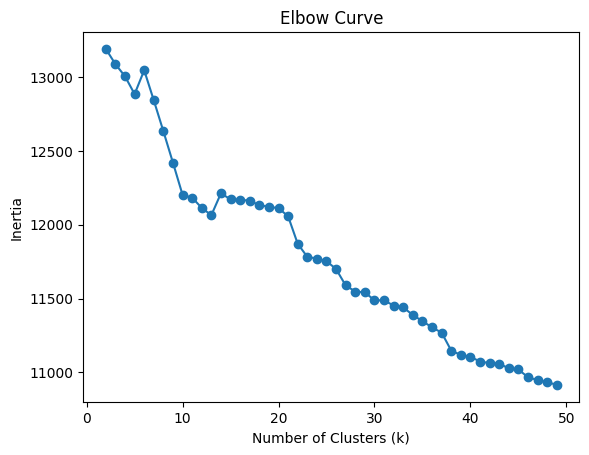

In [22]:
#K-Means
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia_values = []

#I adjusted range from (2, 10) (2, 20) (2, 30) (2, 40) also
k_values = range(2, 50)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertia_values.append(kmeans.inertia_)

#elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


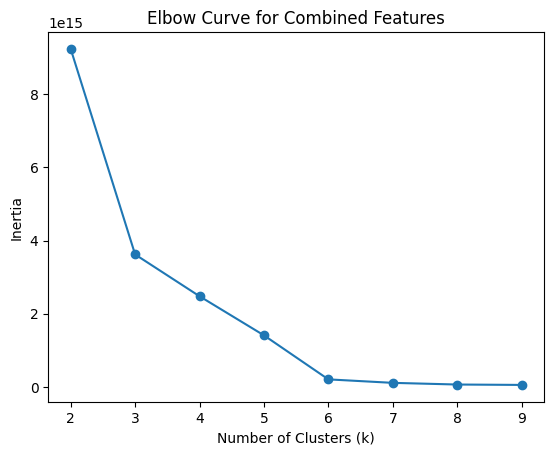

In [52]:
#Kmeans the right way
#In above code I wasn't able to find any elbows even after trying different ranges
#so I decided to combine the features with the tfidf matrix
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

#I converted categorical metadata features to a sparse matrix with the same dtype as tfidf_matrix_csr
metadata_features_encoded_sparse = csr_matrix(metadata_features_encoded.astype(float))

#combining the two
combined_features = hstack((tfidf_matrix_csr, metadata_features_encoded_sparse))

inertia_values_combined = []

k_values = range(2, 10)

for k in k_values:
    kmeans_combined = KMeans(n_clusters=k, random_state=42)
    kmeans_combined.fit(combined_features)
    inertia_values_combined.append(kmeans_combined.inertia_)

#elbow curve
plt.plot(k_values, inertia_values_combined, marker='o')
plt.title('Elbow Curve for Combined Features')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


In [58]:
#I got optimal cluster to be 6 using elbow curve
#Kmeans Clustering after finding the optimal number of clusters
num_clusters = 6
kmeans_combined = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_combined.fit(combined_features)
cluster_labels_combined = kmeans_combined.labels_

print("cluster labels for first 25 samples:", cluster_labels_combined[:25])


cluster labels for first 25 samples: [2 5 3 2 2 4 3 5 4 2 1 3 0 0 3 0 4 3 1 2 2 2 0 1 1]


In [54]:
#interpreting the clusters to find patterns corresponding to different emotions
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(combined_features)
cluster_labels = kmeans.labels_


all_data['cluster'] = cluster_labels
cluster_centers = kmeans.cluster_centers_

#finding cluster centroids and the most frequent emotion in each cluster
for i, centroid in enumerate(cluster_centers):
    print(f"\nCluster {i} Centroid:")
    print(centroid)
    cluster_indices = all_data[all_data['cluster'] == i].index
    most_common_emotion = all_data.loc[cluster_indices, 'emotion'].mode()[0]
    print(f"Most Frequent Emotion: {most_common_emotion}")


Cluster 0 Centroid:
[0.         0.         0.         ... 0.         0.00045725 0.00045725]
Most Frequent Emotion: non-neutral

Cluster 1 Centroid:
[0.00012372 0.         0.00024933 ... 0.000499   0.         0.        ]
Most Frequent Emotion: neutral

Cluster 2 Centroid:
[0.00042938 0.         0.         ... 0.         0.         0.00061709]
Most Frequent Emotion: surprise

Cluster 3 Centroid:
[0.00070188 0.         0.         ... 0.00044924 0.00089847 0.        ]
Most Frequent Emotion: neutral

Cluster 4 Centroid:
[0.00028441 0.00051692 0.         ... 0.00086957 0.00043478 0.        ]
Most Frequent Emotion: neutral

Cluster 5 Centroid:
[0.00016276 0.         0.         ... 0.         0.00078585 0.        ]
Most Frequent Emotion: non-neutral


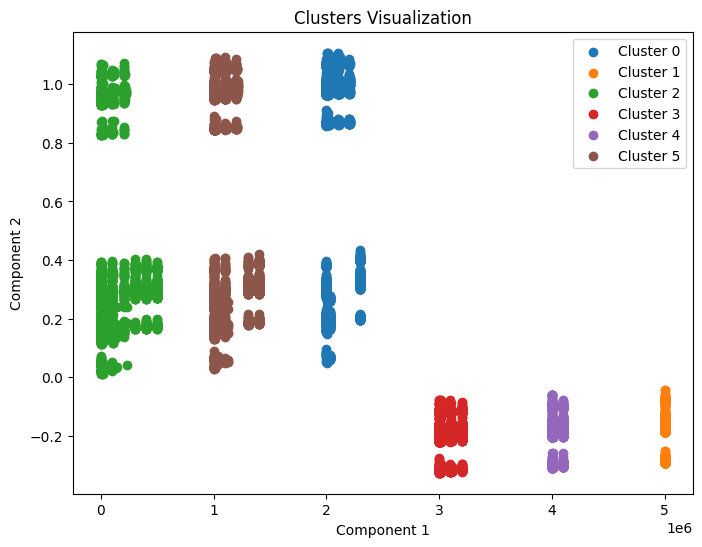

In [59]:
#cluster visualization
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, random_state=42)
combined_features_svd = svd.fit_transform(combined_features)

#plotting clusters
plt.figure(figsize=(8, 6))
for cluster_label in range(6):
    cluster_indices = all_data[all_data['cluster'] == cluster_label].index
    plt.scatter(combined_features_svd[cluster_indices, 0], combined_features_svd[cluster_indices, 1], label=f'Cluster {cluster_label}')

plt.title('Clusters Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()


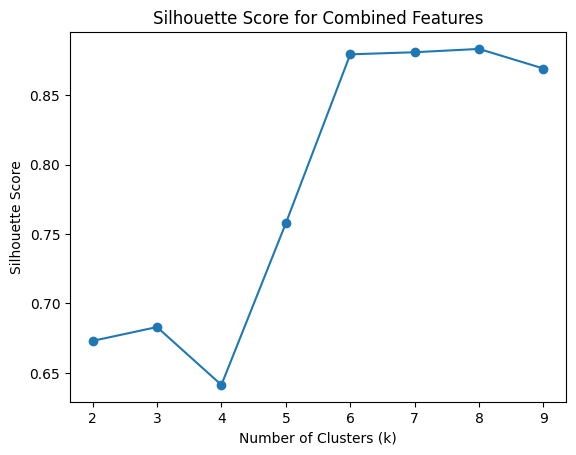

Optimal number of clusters based on silhouette score: 8


In [47]:
#I wanted to check whether the number of clusters I chose were optimal
#So I tried silhoette score, it took me time and I found out that it gave me 8 clusters
#but the scores for 6 and 8 are were close and in elbow curve there was clear indication of elbow on 6 I decided to go with 6 clusters
from sklearn.metrics import silhouette_score
import numpy as np

silhouette_scores_combined = []

k_values = range(2, 10)

for k in k_values:
    kmeans_combined = KMeans(n_clusters=k, random_state=42)
    kmeans_combined.fit(combined_features)
    silhouette_score_combined = silhouette_score(combined_features, kmeans_combined.labels_)
    silhouette_scores_combined.append(silhouette_score_combined)

optimal_k_index = np.argmax(silhouette_scores_combined)
optimal_k = k_values[optimal_k_index]

#plotting scores
plt.plot(k_values, silhouette_scores_combined, marker='o')
plt.title('Silhouette Score for Combined Features')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

print("Optimal number of clusters based on silhouette score:", optimal_k)
